In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass, field
from typing import List, Tuple

%matplotlib ipympl

In [3]:
x, y, h = 10, 20, 30

space = np.array([
    [1, 2, 3, 1],
    [1, 2, 3, 1],
])

In [35]:
@dataclass
class Camera:
    focal_length: float
    resolution: Tuple[int, int]
    sensor_size: Tuple[int, int]

    position: np.ndarray#=field(default_factory=np.array([0., 0., 0.]))
    angle: np.ndarray#=field(default_factory=np.array([0., 1., 0.]))  # angle in degrees

    def __post_init__(self):
        beta, alpha, gamma = self.angle  # R_x, R_y, R_z | pitch, yaw, roll

        sin_beta, cos_beta = np.sin(np.deg2rad(beta)), np.cos(np.deg2rad(beta))
        sin_alpha, cos_alpha = np.sin(np.deg2rad(alpha)), np.cos(np.deg2rad(alpha))
        sin_gamma, cos_gamma = np.sin(np.deg2rad(gamma)), np.cos(np.deg2rad(gamma))

        self.rotation = np.array([
            [cos_alpha*cos_beta, cos_alpha*sin_beta*sin_gamma - sin_alpha*cos_gamma, cos_alpha*sin_beta*cos_gamma + sin_alpha*sin_gamma],
            [sin_alpha*cos_beta, sin_alpha*sin_beta*sin_gamma + cos_alpha*cos_gamma, sin_alpha*sin_beta*cos_gamma - cos_alpha*sin_gamma],
            [-sin_beta, cos_beta*sin_gamma, cos_beta*cos_gamma]
        ])
        unit_vec = np.array([0, 0, 1])
        # v = np.matmul(self.rotation, unit_vec.T)
        v = unit_vec @ self.rotation
        self.unit_angle = v / np.linalg.norm(v)

        self.intrinsic = np.array([
            [self.focal_length*self.resolution[0]/self.sensor_size[0], 0, self.resolution[0]/2],
            [0, self.focal_length*self.resolution[1]/self.sensor_size[1], self.resolution[1]/2],
            [0, 0, 1]
        ])

        # print('intrinsic')
        # print(self.intrinsic)
        
    '''
        Transform world coordinate to pixel coordinate
            - World to camera coordinate
            - Camera to pixel coordinate
    '''
    def transform(self, 
        space,
        world_position
    ):
        # convention assumption on viewing angles
        translation = np.array(self.position - world_position)  # row vector
        m = np.zeros((4, 4))
        m[0:3, 0:3] = self.rotation
        m[0:3, -1] = translation
        m[-1, -1] = 1

        # image_space = np.matmul(space, m)
        image_space = np.matmul(m, space.T).T
        camera_space = np.matmul(self.intrinsic, image_space.T).T
        pixel_space = np.matmul(self.abc, camera_space.T).T

        return pixel_space

    def pixel2ray(self, pixel):
        pixel = np.append(pixel, np.zeros((pixel.shape[0], 1)) + 1, axis=-1)
        # pixel = pixel / self.focal_length
        translation = np.array(self.position) 
        camera_coor = pixel @ np.linalg.inv(self.intrinsic.T)
        print('coor', camera_coor)
        # camera_coor = pixel @ np.linalg.inv(self.intrinsic).T
        world_coor = (camera_coor @ self.rotation) + translation
        print('world', world_coor)

        vector = world_coor - self.position
        directional_vector = vector / np.linalg.norm(vector)

        return directional_vector

# camera = Camera(16.16003, (512, 512), np.array([8, 2.5, 3]), (17.288, 232.093, 0))
camera = Camera(20., (512, 512), (36, 36), np.array([0, 0, 0]), (0, 0, 0))
pixel = np.array([[250, 250]])
ray = camera.pixel2ray(pixel)
print(ray, camera.unit_angle, 1.5*ray)

coor [[-0.02109375 -0.02109375  1.        ]]
world [[-0.02109375 -0.02109375  1.        ]]
[[-0.02108437 -0.02108437  0.99955535]] [0. 0. 1.] [[-0.03162656 -0.03162656  1.49933303]]


coor [[-0.9       -0.9        1.       ]
 [-0.9        0.9        1.       ]
 [ 0.9       -0.9        1.       ]
 [ 0.9        0.9        1.       ]
 [ 0.50625    0.1546875  1.       ]]
world [[-0.9       -0.9        1.       ]
 [-0.9        0.9        1.       ]
 [ 0.9       -0.9        1.       ]
 [ 0.9        0.9        1.       ]
 [ 0.50625    0.1546875  1.       ]]


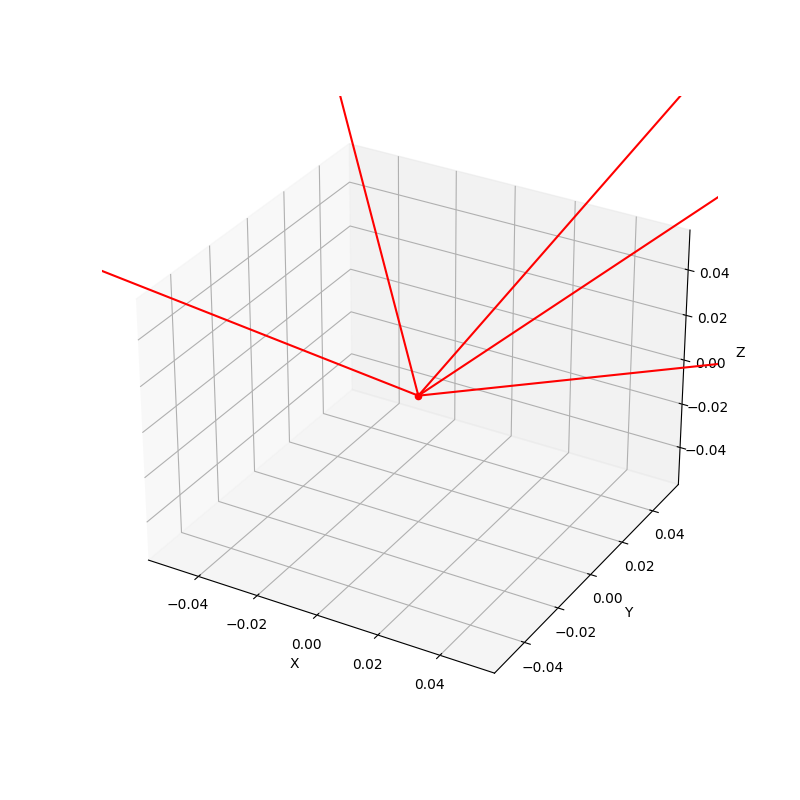

In [36]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.scatter(*camera.position, color='red')

pixels = np.array([
    [0, 0],
    [0, 512],
    [512, 0],
    [512, 512],
    [400, 300],
])
# for pixel in pixels:
#     ax.scatter(*pixel, color='teal')
rays = camera.pixel2ray(pixels)

stack_origin = np.stack([camera.position]*pixels.shape[0])
ax.quiver(
    stack_origin[:, 0],
    stack_origin[:, 1],
    stack_origin[:, 2],
    rays[:, 0],
    rays[:, 1],
    rays[:, 2],
    color='red', length=1.0, arrow_length_ratio=.1, normalize=True
)

# ax.quiver(*camera.position, *v, color='red')

# plt.axis('off')
plt.show()

In [ ]:
beta, alpha, gamma = [30, 0, 0]  # R_x, R_y, R_z | pitch, yaw, roll

sin_beta, cos_beta = np.sin(np.deg2rad(beta)), np.cos(np.deg2rad(beta))
sin_alpha, cos_alpha = np.sin(np.deg2rad(alpha)), np.cos(np.deg2rad(alpha))
sin_gamma, cos_gamma = np.sin(np.deg2rad(gamma)), np.cos(np.deg2rad(gamma))

np.array([
    [cos_alpha*cos_beta, cos_alpha*sin_beta*sin_gamma - sin_alpha*cos_gamma, cos_alpha*sin_beta*cos_gamma + sin_alpha*sin_gamma],
    [sin_alpha*cos_beta, sin_alpha*sin_beta*sin_gamma + cos_alpha*cos_gamma, sin_alpha*sin_beta*cos_gamma - cos_alpha*sin_gamma],
    [-sin_beta, cos_beta*sin_gamma, cos_beta*cos_gamma]
])

In [ ]:
np.stack([camera.position]*4)[:, 0]

In [22]:
np.iinfo(np.uint8)

iinfo(min=0, max=255, dtype=uint8)